## Prediction model

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import torch.nn.functional as F

n_component=12

class FNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_component,128)
        self.fc2 = nn.Linear(128, 512)
        self.dp1 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(512, 256)
        self.dp2 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(16, 1)
        
    def forward(self, x):
        h = F.selu(self.fc1(x)) #best: selu, leaky_relu
        h = F.selu(self.fc2(h))
        h = self.dp1(h)
        h = F.selu(self.fc3(h))
        h = self.dp2(h)
        h = F.selu(self.fc4(h))
        h = F.selu(self.fc5(h))
        h = F.selu(self.fc6(h))
        h = F.selu(self.fc7(h))
        out = self.fc8(h)
        return out
    
    def fit(self, data_loader, criterion, optimizer):
        self.train()
        sum_train_losses = 0

        for data, target in data_loader:
            
            optimizer.zero_grad()
            pred = self(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            sum_train_losses += loss.item()

        return sum_train_losses / len(data_loader)

    def predict(self, data_loader):
        self.eval()
        list_preds = list()

        with torch.no_grad():
            for data, _ in data_loader:
                pred = self(data)
                list_preds.append(pred)

        return torch.cat(list_preds, dim=0).cpu().numpy() 

class FNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_component,128)
        self.fc2 = nn.Linear(128, 256)
        self.dp1 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 128)
        self.fc5 = nn.Linear(128, 1)
        
    def forward(self, x):
        h = F.selu(self.fc1(x)) #best: selu, leaky_relu
        h = F.selu(self.fc2(h))
        h = self.dp1(h)
        h = F.selu(self.fc3(h))
        h = F.selu(self.fc4(h))
        out = self.fc5(h)
        return out
    
    def fit(self, data_loader, criterion, optimizer):
        self.train()
        sum_train_losses = 0

        for data, target in data_loader:
            
            optimizer.zero_grad()
            pred = self(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            sum_train_losses += loss.item()

        return sum_train_losses / len(data_loader)

    def predict(self, data_loader):
        self.eval()
        list_preds = list()

        with torch.no_grad():
            for data, _ in data_loader:
                pred = self(data)
                list_preds.append(pred)

        return torch.cat(list_preds, dim=0).cpu().numpy()

In [2]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [3]:
train_set = pd.read_csv('split/train_split.csv')
test_set = pd.read_csv('split/test_split.csv')

train_set = np.delete(train_set, [0], 1).astype(float)
test_set = np.delete(test_set, [0], 1).astype(float)

nFeat = len(train_set[0,:]) - 2

X_train = train_set[:,:nFeat]
X_test = test_set[:,:nFeat]
Y_train_1 = train_set[:,nFeat:nFeat+1]
Y_test_1 = test_set[:,nFeat:nFeat+1]
Y_train_2 = train_set[:,nFeat+1:nFeat+2]
Y_test_2 = test_set[:,nFeat+1:nFeat+2]

In [4]:
#scaler, w/o time
scalerx = RobustScaler().fit (X_train)
X_train = scalerx.transform(X_train)
X_test  = scalerx.transform(X_test)

model:  KR rbf
R2 score:     0.68		0.39
model:  SVM rbf
R2 score:     0.6		0.03
model:  kNN
R2 score:     0.61		0.27
model:  Random forest
R2 score:     0.75		0.75
model:  Xgboost
R2 score:     0.7		0.62
model:  FNN
R2 score:     0.86		0.72


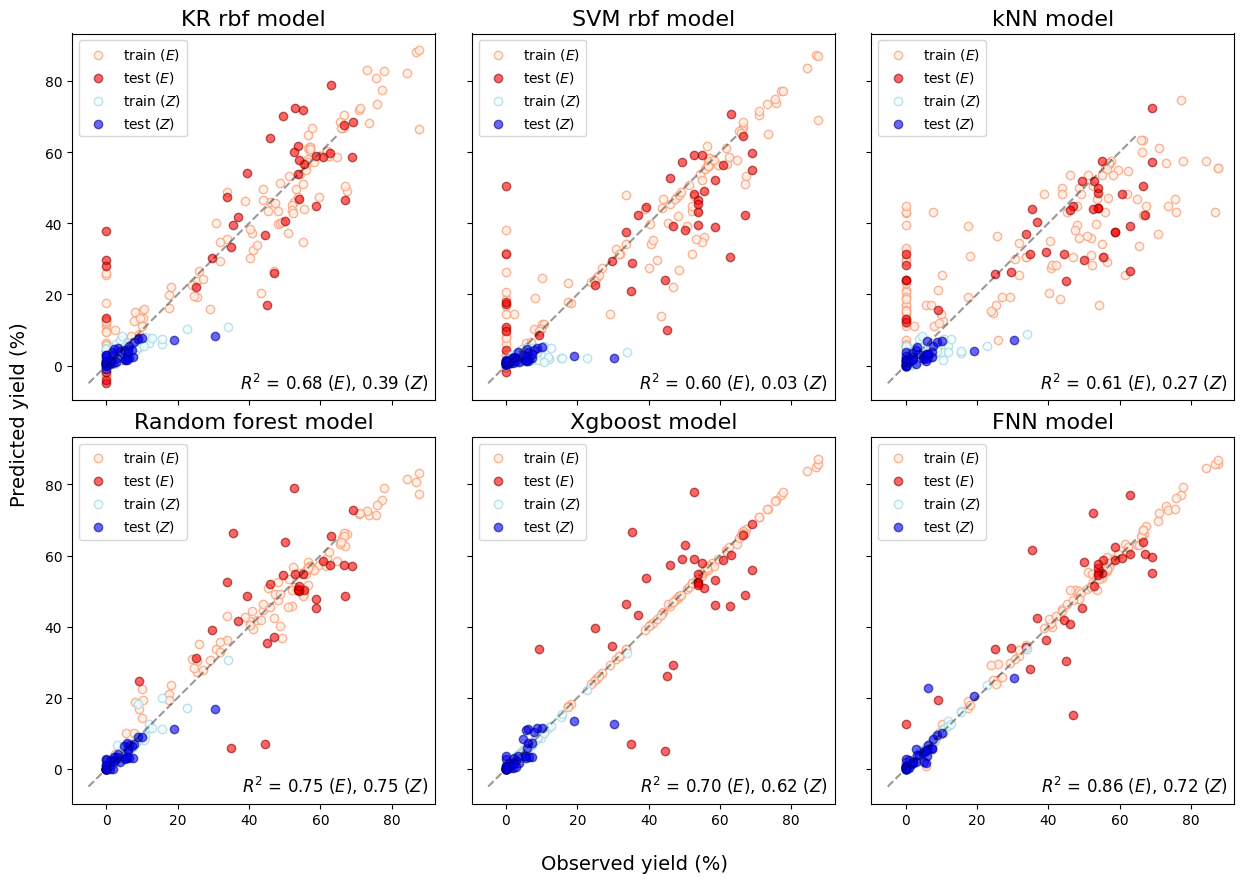

In [5]:
model_1 = {}
model_2 = {}

model_1['KR rbf'] =GridSearchCV(KernelRidge(kernel='rbf'), cv=5, 
                               param_grid={'alpha': [10, 1, 0.1, 1e-2, 1e-3, 1e-4], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
                              scoring ='r2')
model_2['KR rbf'] =GridSearchCV(KernelRidge(kernel='rbf'), cv=5, 
                               param_grid={'alpha': [10, 1, 0.1, 1e-2, 1e-3, 1e-4], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
                              scoring ='r2')

model_1['SVM rbf'] = GridSearchCV(SVR(kernel='rbf'), cv=5, 
                                 param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.5, 1, 2]}, 
                                 scoring ='r2')
model_2['SVM rbf'] = GridSearchCV(SVR(kernel='rbf'), cv=5, 
                                 param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.5, 1, 2]}, 
                                 scoring ='r2')

model_1['kNN'] = GridSearchCV(KNeighborsRegressor(), cv=5, param_grid={'n_neighbors':[3,4,5,6,7]}, scoring ='r2')
model_2['kNN'] = GridSearchCV(KNeighborsRegressor(), cv=5, param_grid={'n_neighbors':[3,4,5,6,7]}, scoring ='r2')

model_1['Random forest'] = GridSearchCV(RandomForestRegressor(),cv=5, #
                                 param_grid ={'max_depth': [5,10,15,20,25,30,35,40], 'n_estimators': [20,40,80,120,160,200,240,280]}, 
                                 scoring='r2')
model_2['Random forest'] = GridSearchCV(RandomForestRegressor(),cv=5, #
                                 param_grid ={'max_depth': [5,10,15,20,25,30,35,40], 'n_estimators': [20,40,80,120,160,200,240,280]}, 
                                 scoring='r2')

model_1['Xgboost'] = GridSearchCV(xgb.XGBRegressor(), cv=5,
                                  param_grid ={'max_depth': [2,5,10,15,20,25,30], 'n_estimators': [20,40,80,120,160,200,240,280]},
                                  scoring='r2')
model_2['Xgboost'] = GridSearchCV(xgb.XGBRegressor(), cv=5,
                                  param_grid ={'max_depth': [2,5,10,15,20,25,30], 'n_estimators': [20,40,80,120,160,200,240,280]},
                                  scoring='r2')

model_1['FNN'] = FNN1()
model_2['FNN'] = FNN2()

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex = True, sharey = True)

for idx, model in enumerate(model_1):
    print('model: ', model)
    row = idx//3
    col = idx%3
    
    if model == 'FNN':
        random_seed = 1
        X_train_1, X_val_1, Y_train_1i, Y_val_1 = train_test_split(X_train, Y_train_1, test_size=0.22, shuffle=True, random_state=random_seed)
        X_train_2, X_val_2, Y_train_2i, Y_val_2 = train_test_split(X_train, Y_train_2, test_size=0.22, shuffle=True, random_state=random_seed)
        
        X_train_1t = torch.Tensor(X_train_1)
        X_val_1t = torch.Tensor(X_val_1)
        X_test_1t = torch.Tensor(X_test)
        Y_train_1t = torch.Tensor(Y_train_1i)
        Y_val_1t = torch.Tensor(Y_val_1)
        Y_test_1t = torch.Tensor(Y_test_1)
        X_train_2t = torch.Tensor(X_train_2)
        X_val_2t = torch.Tensor(X_val_2)
        X_test_2t = torch.Tensor(X_test)
        Y_train_2t = torch.Tensor(Y_train_2i)
        Y_val_2t = torch.Tensor(Y_val_2)
        Y_test_2t = torch.Tensor(Y_test_2)

        data_train_1 = TensorDataset(X_train_1t, Y_train_1t)
        data_val_1 = TensorDataset(X_val_1t, Y_val_1t)
        data_test_1 = TensorDataset(X_test_1t, Y_test_1t)
        train_loader_1 = DataLoader(data_train_1, batch_size=64, shuffle=False)
        val_loader_1 = DataLoader(data_val_1, batch_size=64, shuffle=False)
        test_loader_1 = DataLoader(data_test_1, batch_size=64, shuffle=False)
        data_train_2 = TensorDataset(X_train_2t, Y_train_2t)
        data_val_2 = TensorDataset(X_val_2t, Y_val_2t)
        data_test_2 = TensorDataset(X_test_2t, Y_test_2t)
        train_loader_2 = DataLoader(data_train_2, batch_size=64, shuffle=False)
        val_loader_2 = DataLoader(data_val_2, batch_size=64, shuffle=False)
        test_loader_2 = DataLoader(data_test_2, batch_size=64, shuffle=False)

        criterion = nn.MSELoss()
        optimizer_1 = optim.Adam(model_1[model].parameters())
        optimizer_2 = optim.Adam(model_2[model].parameters())

        for epoch in range(1000):
            model_1[model].train()
            train_loss_1 = model_1[model].fit(train_loader_1, criterion, optimizer_1)
            model_1[model].eval()
            val_loss_1 = model_1[model].fit(val_loader_1, criterion, optimizer_1)
        for epoch in range(1000):
            model_2[model].train()
            train_loss_2 = model_2[model].fit(train_loader_2, criterion, optimizer_2)
            model_1[model].eval()
            val_loss_2 = model_2[model].fit(val_loader_2, criterion, optimizer_2)
            
        Y_pred_1 = model_1[model].predict(test_loader_1)
        Y_test_1t = Y_test_1t.detach().numpy()
        Y_train_out_1 = model_1[model].predict(train_loader_1)
        Y_train_1t = Y_train_1t.detach().numpy()
        Y_val_out_1 = model_1[model].predict(val_loader_1)
        Y_val_1t = Y_val_1t.detach().numpy()
        r2_yield1 = np.around(r2_score(Y_test_1t,Y_pred_1), 2)
        Y_pred_2 = model_2[model].predict(test_loader_2)
        Y_test_2t = Y_test_2t.detach().numpy()
        Y_train_out_2 = model_2[model].predict(train_loader_2)
        Y_train_2t = Y_train_2t.detach().numpy()
        Y_val_out_2 = model_2[model].predict(val_loader_2)
        Y_val_2t = Y_val_2t.detach().numpy()
        r2_yield2 = np.around(r2_score(Y_test_2t,Y_pred_2), 2)
        
        print('R2 score:     {}\t\t{}'.format(r2_yield1, r2_yield2))

        axes[row, col].scatter(Y_train_1t, Y_train_out_1, edgecolors='lightsalmon', facecolors='linen', alpha=0.8, label='train ($\mathit{E}$)')
        axes[row, col].scatter(Y_val_1t, Y_val_out_1, edgecolors='lightsalmon', facecolors='linen', alpha=0.8)
        axes[row, col].scatter(Y_test_1t, Y_pred_1, edgecolors='darkred', facecolors='red', alpha=0.6, label='test ($\mathit{E}$)')
        axes[row, col].scatter(Y_train_2t, Y_train_out_2, edgecolors='lightblue', facecolors='azure', alpha=0.8, label='train ($\mathit{Z}$)')
        axes[row, col].scatter(Y_val_2t, Y_val_out_2, edgecolors='lightblue', facecolors='azure', alpha=0.8)
        axes[row, col].scatter(Y_test_2t, Y_pred_2, edgecolors='darkblue', facecolors='blue', alpha=0.6, label='test ($\mathit{Z}$)')
        axes[row, col].set_title('{} model'.format(model), fontsize=16)
        axes[row, col].legend(loc='best')
        axes[row, col].annotate(r'$R^2$ = {:.2f} '.format(r2_yield1)+'($\mathit{E}$), '+r'{:.2f} '.format(r2_yield2)+'($\mathit{Z}$)', xy=(1,0), xycoords='axes fraction', xytext=(-5, 5), textcoords='offset points',
                            ha='right', va='bottom', fontsize=12)
        axes[row, col].plot([-5,65], [-5,65], ls = "--", color = 'black', alpha=0.4)

    
    else:

        model_1[model].fit(X_train, Y_train_1[:,0])
        Y_pred1 = model_1[model].predict (X_test)
        r2_yield1 = np.around(r2_score(Y_test_1, Y_pred1), 2)
        Y_train_out1 = model_1[model].predict(X_train)
        
        model_2[model].fit(X_train, Y_train_2[:,0])
        Y_pred2 = model_2[model].predict (X_test)
        r2_yield2 = np.around(r2_score(Y_test_2, Y_pred2), 2)
        Y_train_out2 = model_2[model].predict(X_train)
        
        print('R2 score:     {}\t\t{}'.format(r2_yield1, r2_yield2))

        
        axes[row, col].scatter(Y_train_1, Y_train_out1, edgecolors='lightsalmon', facecolors='linen', alpha=0.8, label='train ($\it{E}$)')
        axes[row, col].scatter(Y_test_1, Y_pred1, edgecolors='darkred', facecolors='red', alpha=0.6, label='test ($\it{E}$)')
        axes[row, col].set_title('{} model'.format(model), fontsize=16)
        axes[row, col].scatter(Y_train_2, Y_train_out2, edgecolors='lightblue', facecolors='azure', alpha=0.8, label='train ($\it{Z}$)')
        axes[row, col].scatter(Y_test_2, Y_pred2, edgecolors='darkblue', facecolors='blue', alpha=0.6, label='test ($\it{Z}$)')
        axes[row, col].set_title('{} model'.format(model), fontsize=16)
        axes[row, col].legend(loc='best')
        axes[row, col].annotate(r'$R^2$ = {:.2f} '.format(r2_yield1)+'($\mathit{E}$), '+r'{:.2f} '.format(r2_yield2)+'($\mathit{Z}$)', xy=(1,0), xycoords='axes fraction', xytext=(-5, 5), textcoords='offset points',
                            ha='right', va='bottom', fontsize=12)
        axes[row, col].plot([-5,65], [-5,65], ls = "--", color = 'black', alpha=0.4)

fig.text(0.5, 0.05, 'Observed yield (%)', ha='center', va='center', fontsize=14)
fig.text(0.09, 0.5, 'Predicted yield (%)', ha='center', va='center', rotation='vertical', fontsize=14)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [6]:
#save image
fig.savefig('all_original_models.png')

In [7]:
np.savetxt("Y_pred_1t_original_"+str(random_seed)+".csv", Y_pred_1, delimiter=",")
np.savetxt("Y_pred_2t_original_"+str(random_seed)+".csv", Y_pred_2, delimiter=",")
torch.save(model_1,"original_model_1"+str(random_seed)+".pt")
torch.save(model_2,"original_model_2"+str(random_seed)+".pt")